In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_moons

import numpy as np
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel
import warnings

from 

In [50]:
class SVMPlus(BaseEstimator, ClassifierMixin):
    """
    SVM+ (Support Vector Machine with Privileged Information) implementation
    
    This implementation follows the formulation from Vapnik's paper:
    "Learning Using Privileged Information: Similarity Control and Knowledge Transfer"
    """
    
    def __init__(self, C=1.0, gamma=1.0, kernel='rbf', kernel_star='rbf', 
                 kernel_params=None, kernel_star_params=None, tol=1e-6, max_iter=1000):
        """
        Initialize SVM+ classifier
        
        Parameters:
        -----------
        C : float, default=1.0
            Regularization parameter
        gamma : float, default=1.0
            Regularization parameter for privileged information
        kernel : str or callable, default='rbf'
            Kernel function for regular features
        kernel_star : str or callable, default='rbf'
            Kernel function for privileged features
        kernel_params : dict, default=None
            Parameters for regular kernel
        kernel_star_params : dict, default=None
            Parameters for privileged kernel
        tol : float, default=1e-6
            Tolerance for optimization
        max_iter : int, default=1000
            Maximum iterations for optimization
        """
        self.C = C
        self.gamma = gamma
        self.kernel = kernel
        self.kernel_star = kernel_star
        self.kernel_params = kernel_params or {}
        self.kernel_star_params = kernel_star_params or {}
        self.tol = tol
        self.max_iter = max_iter
        
    def _get_kernel_function(self, kernel_type, params):
        """Get kernel function based on type and parameters"""
        if kernel_type == 'linear':
            return lambda X, Y: linear_kernel(X, Y, **params)
        elif kernel_type == 'rbf':
            return lambda X, Y: rbf_kernel(X, Y, **params)
        elif kernel_type == 'poly':
            return lambda X, Y: polynomial_kernel(X, Y, **params)
        elif callable(kernel_type):
            return kernel_type
        else:
            raise ValueError(f"Unknown kernel type: {kernel_type}")
    
    def _compute_kernel_matrix(self, X, Y, kernel_func):
        """Compute kernel matrix between X and Y"""
        return kernel_func(X, Y)
    
    def fit(self, X, X_star, y):
        """
        Fit SVM+ model
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Regular training features
        X_star : array-like, shape (n_samples, n_privileged_features)
            Privileged training features
        y : array-like, shape (n_samples,)
            Target values (-1 or 1)
        """
        X = np.array(X)
        X_star = np.array(X_star)
        y = np.array(y)
        
        # Ensure y is in {-1, 1}
        unique_y = np.unique(y)
        if set(unique_y) != {-1, 1}:
            # Convert to {-1, 1} if needed
            y_binary = np.where(y == unique_y[0], -1, 1)
            self.classes_ = unique_y
            y = y_binary
        else:
            self.classes_ = np.array([-1, 1])
        
        self.n_samples_ = X.shape[0]
        self.X_train_ = X
        self.X_star_train_ = X_star
        self.y_train_ = y
        
        # Get kernel functions
        self.kernel_func_ = self._get_kernel_function(self.kernel, self.kernel_params)
        self.kernel_star_func_ = self._get_kernel_function(self.kernel_star, self.kernel_star_params)
        
        # Compute kernel matrices
        self.K_ = self._compute_kernel_matrix(X, X, self.kernel_func_)
        self.K_star_ = self._compute_kernel_matrix(X_star, X_star, self.kernel_star_func_)
        
        # Solve dual optimization problem
        self._solve_dual()
        
        # Compute bias terms
        self._compute_bias()
        
        return self
    
    def _solve_dual(self):
        """Solve the dual optimization problem"""
        n = self.n_samples_
        
        # Initial guess for alpha and beta
        x0 = np.zeros(2 * n)
        
        # Bounds: alpha_i >= 0, 0 <= beta_i <= C
        bounds = [(0, None) for _ in range(n)] + [(0, self.C) for _ in range(n)]
        
        # Constraints
        constraints = [
            # Sum(alpha_i * y_i) = 0
            {
                'type': 'eq',
                'fun': lambda x: np.sum(x[:n] * self.y_train_),
                'jac': lambda x: np.concatenate([self.y_train_, np.zeros(n)])
            },
            # Sum(alpha_i - beta_i) = 0
            {
                'type': 'eq',
                'fun': lambda x: np.sum(x[:n] - x[n:]),
                'jac': lambda x: np.concatenate([np.ones(n), -np.ones(n)])
            }
        ]
        
        # Solve optimization problem
        result = minimize(
            fun=self._dual_objective,
            x0=x0,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': self.max_iter, 'ftol': self.tol}
        )
        
        if not result.success:
            warnings.warn(f"Optimization did not converge: {result.message}")
        
        # Extract alpha and beta
        self.alpha_ = result.x[:n]
        self.beta_ = result.x[n:]
        
        # Find support vectors
        self.support_mask_ = self.alpha_ > self.tol
        self.support_ = np.where(self.support_mask_)[0]
        self.n_support_ = len(self.support_)
        
    def _dual_objective(self, x):
        """Dual objective function to minimize (negative of the original maximization)"""
        n = self.n_samples_
        alpha = x[:n]
        beta = x[n:]
        
        # First term: -sum(alpha_i)
        term1 = -np.sum(alpha)
        
        # Second term: 1/2 * sum_ij(alpha_i * alpha_j * y_i * y_j * K(x_i, x_j))
        term2 = 0.5 * np.sum(alpha[:, np.newaxis] * alpha[np.newaxis, :] * 
                            self.y_train_[:, np.newaxis] * self.y_train_[np.newaxis, :] * 
                            self.K_)
        
        # Third term: 1/(2*gamma) * sum_ij((alpha_i - beta_i) * (alpha_j - beta_j) * K*(x*_i, x*_j))
        alpha_minus_beta = alpha - beta
        term3 = (1.0 / (2.0 * self.gamma)) * np.sum(
            alpha_minus_beta[:, np.newaxis] * alpha_minus_beta[np.newaxis, :] * self.K_star_)
        
        return term1 + term2 + term3
    
    def _compute_bias(self):
        """Compute bias terms b and b*"""
        if self.n_support_ == 0:
            self.b_ = 0.0
            self.b_star_ = 0.0
            return
        
        # For support vectors with 0 < alpha_i < C, we can compute b
        # yi * (sum(alpha_j * yj * K(xi, xj)) + b) = 1 - (w*, z*i) - b*
        
        # Find support vectors that are not on the boundary
        free_sv_mask = (self.alpha_ > self.tol) & (self.alpha_ < self.C - self.tol)
        free_sv_indices = np.where(free_sv_mask)[0]
        
        if len(free_sv_indices) > 0:
            # Use the first free support vector to compute b
            i = free_sv_indices[0]
            
            # Compute decision function without bias
            decision_no_bias = np.sum(self.alpha_ * self.y_train_ * self.K_[i, :])
            
            # Compute privileged part
            privileged_part = np.sum((self.alpha_ - self.beta_) * self.K_star_[i, :]) / self.gamma
            
            # b = yi * (1 - privileged_part) - decision_no_bias
            self.b_ = self.y_train_[i] * (1.0 - privileged_part) - decision_no_bias
            
            # For b*, we use the relation: xi = (w*, z*i) + b*
            # From the slack function definition
            self.b_star_ = privileged_part - np.sum((self.alpha_ - self.beta_) * self.K_star_[i, :]) / self.gamma
        else:
            # Fallback: use average over all support vectors
            self.b_ = 0.0
            self.b_star_ = 0.0
    
    def decision_function(self, X):
        """
        Compute the decision function for samples in X
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Test samples
            
        Returns:
        --------
        decision : array, shape (n_samples,)
            Decision function values
        """
        X = np.array(X)
        
        # Compute kernel between test and training samples
        K_test = self._compute_kernel_matrix(X, self.X_train_, self.kernel_func_)
        
        # Decision function: sum(alpha_i * y_i * K(x, x_i)) + b
        # K_test shape: (n_test_samples, n_train_samples)
        # alpha_ and y_train_ shape: (n_train_samples,)
        # We need to compute: K_test @ (alpha_ * y_train_)
        decision = K_test @ (self.alpha_ * self.y_train_) + self.b_
        
        return decision
    
    def predict(self, X):
        """
        Predict class labels for samples in X
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Test samples
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Predicted class labels
        """
        decision = self.decision_function(X)
        predictions = np.sign(decision)
        
        # Convert back to original class labels if needed
        if hasattr(self, 'classes_') and len(self.classes_) == 2:
            predictions = np.where(predictions == -1, self.classes_[0], self.classes_[1])
        
        return predictions
    
    def get_params(self, deep=True):
        """Get parameters for this estimator"""
        return {
            'C': self.C,
            'gamma': self.gamma,
            'kernel': self.kernel,
            'kernel_star': self.kernel_star,
            'kernel_params': self.kernel_params,
            'kernel_star_params': self.kernel_star_params,
            'tol': self.tol,
            'max_iter': self.max_iter
        }
    
    def set_params(self, **params):
        """Set parameters for this estimator"""
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [51]:

class MulticlassSVMPlus(BaseEstimator, ClassifierMixin):
    """
    Multiclass SVM+ using One-vs-One strategy
    
    Extends SVM+ to handle multiclass problems by training binary SVM+ classifiers
    for each pair of classes and using voting for prediction.
    """
    
    def __init__(self, C=1.0, gamma=1.0, kernel='rbf', kernel_star='rbf', 
                 kernel_params=None, kernel_star_params=None, tol=1e-6, max_iter=1000):
        """
        Initialize Multiclass SVM+ classifier
        
        Parameters:
        -----------
        C : float, default=1.0
            Regularization parameter
        gamma : float, default=1.0
            Regularization parameter for privileged information
        kernel : str or callable, default='rbf'
            Kernel function for regular features
        kernel_star : str or callable, default='rbf'
            Kernel function for privileged features
        kernel_params : dict, default=None
            Parameters for regular kernel
        kernel_star_params : dict, default=None
            Parameters for privileged kernel
        tol : float, default=1e-6
            Tolerance for optimization
        max_iter : int, default=1000
            Maximum iterations for optimization
        """
        self.C = C
        self.gamma = gamma
        self.kernel = kernel
        self.kernel_star = kernel_star
        self.kernel_params = kernel_params or {}
        self.kernel_star_params = kernel_star_params or {}
        self.tol = tol
        self.max_iter = max_iter
        
    def fit(self, X, X_star, y):
        """
        Fit Multiclass SVM+ model using One-vs-One strategy
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Regular training features
        X_star : array-like, shape (n_samples, n_privileged_features)
            Privileged training features
        y : array-like, shape (n_samples,)
            Target values (multiclass labels)
        """
        X = np.array(X)
        X_star = np.array(X_star)
        y = np.array(y)
        
        # Store unique classes
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        if self.n_classes_ == 2:
            # Binary case - use single SVM+
            self.binary_classifiers_ = [SVMPlus(
                C=self.C, gamma=self.gamma, kernel=self.kernel, 
                kernel_star=self.kernel_star, kernel_params=self.kernel_params,
                kernel_star_params=self.kernel_star_params, tol=self.tol, max_iter=self.max_iter
            )]
            self.binary_classifiers_[0].fit(X, X_star, y)
            self.class_pairs_ = [(self.classes_[0], self.classes_[1])]
        else:
            # Multiclass case - One-vs-One strategy
            self.binary_classifiers_ = []
            self.class_pairs_ = []
            
            # Train binary classifier for each pair of classes
            for i in range(self.n_classes_):
                for j in range(i + 1, self.n_classes_):
                    class_i, class_j = self.classes_[i], self.classes_[j]
                    
                    # Get samples for this pair of classes
                    pair_mask = (y == class_i) | (y == class_j)
                    X_pair = X[pair_mask]
                    X_star_pair = X_star[pair_mask]
                    y_pair = y[pair_mask]
                    
                    # Convert to binary labels {-1, 1}
                    y_binary = np.where(y_pair == class_i, -1, 1)
                    
                    # Train binary SVM+ classifier
                    clf = SVMPlus(
                        C=self.C, gamma=self.gamma, kernel=self.kernel,
                        kernel_star=self.kernel_star, kernel_params=self.kernel_params,
                        kernel_star_params=self.kernel_star_params, tol=self.tol, max_iter=self.max_iter
                    )
                    clf.fit(X_pair, X_star_pair, y_binary)
                    
                    self.binary_classifiers_.append(clf)
                    self.class_pairs_.append((class_i, class_j))
        
        return self
    
    def decision_function(self, X):
        """
        Compute decision function values for all class pairs
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Test samples
            
        Returns:
        --------
        decision : array, shape (n_samples, n_classifiers)
            Decision function values for each binary classifier
        """
        X = np.array(X)
        n_samples = X.shape[0]
        n_classifiers = len(self.binary_classifiers_)
        
        decisions = np.zeros((n_samples, n_classifiers))
        
        for i, clf in enumerate(self.binary_classifiers_):
            decisions[:, i] = clf.decision_function(X)
            
        return decisions
    
    def predict(self, X):
        """
        Predict class labels using majority voting
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Test samples
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Predicted class labels
        """
        X = np.array(X)
        n_samples = X.shape[0]
        
        if self.n_classes_ == 2:
            # Binary case
            return self.binary_classifiers_[0].predict(X)
        
        # Multiclass case - voting
        votes = np.zeros((n_samples, self.n_classes_))
        
        for i, (clf, (class_i, class_j)) in enumerate(zip(self.binary_classifiers_, self.class_pairs_)):
            predictions = clf.predict(X)
            
            # Convert binary predictions back to original classes
            for k, pred in enumerate(predictions):
                if pred == -1:  # Predicted class_i
                    class_idx = np.where(self.classes_ == class_i)[0][0]
                    votes[k, class_idx] += 1
                else:  # Predicted class_j
                    class_idx = np.where(self.classes_ == class_j)[0][0]
                    votes[k, class_idx] += 1
        
        # Return class with most votes
        predicted_indices = np.argmax(votes, axis=1)
        return self.classes_[predicted_indices]
    
    def predict_proba(self, X):
        """
        Predict class probabilities using normalized votes
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Test samples
            
        Returns:
        --------
        proba : array, shape (n_samples, n_classes)
            Predicted class probabilities
        """
        X = np.array(X)
        n_samples = X.shape[0]
        
        if self.n_classes_ == 2:
            # Binary case - use decision function
            decisions = self.binary_classifiers_[0].decision_function(X)
            # Convert to probabilities using sigmoid-like function
            proba_pos = 1 / (1 + np.exp(-decisions))
            proba_neg = 1 - proba_pos
            return np.column_stack([proba_neg, proba_pos])
        
        # Multiclass case - use votes as proxy for probabilities
        votes = np.zeros((n_samples, self.n_classes_))
        
        for i, (clf, (class_i, class_j)) in enumerate(zip(self.binary_classifiers_, self.class_pairs_)):
            decisions = clf.decision_function(X)
            
            # Use decision function values as confidence
            for k, decision in enumerate(decisions):
                if decision < 0:  # Favors class_i
                    class_idx = np.where(self.classes_ == class_i)[0][0]
                    votes[k, class_idx] += abs(decision)
                else:  # Favors class_j
                    class_idx = np.where(self.classes_ == class_j)[0][0]
                    votes[k, class_idx] += abs(decision)
        
        # Normalize to get probabilities
        vote_sums = votes.sum(axis=1, keepdims=True)
        vote_sums[vote_sums == 0] = 1  # Avoid division by zero
        probabilities = votes / vote_sums
        
        return probabilities
    
    def get_params(self, deep=True):
        """Get parameters for this estimator"""
        return {
            'C': self.C,
            'gamma': self.gamma,
            'kernel': self.kernel,
            'kernel_star': self.kernel_star,
            'kernel_params': self.kernel_params,
            'kernel_star_params': self.kernel_star_params,
            'tol': self.tol,
            'max_iter': self.max_iter
        }
    
    def set_params(self, **params):
        """Set parameters for this estimator"""
        for param, value in params.items():
            setattr(self, param, value)
        return self




Dataset: moons
SVM+ accuracy: 0.900
Standard SVM accuracy: 0.933
Improvement: -0.033


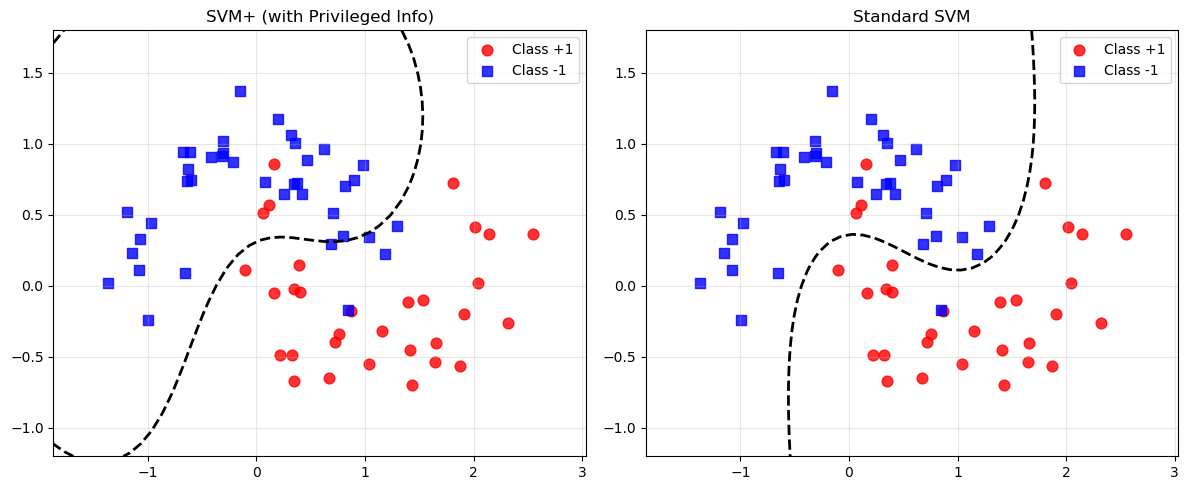

In [52]:
def plot_svm_comparison():
    """
    Simple comparison of SVM+ vs standard SVM using moons dataset
    """
    np.random.seed(42)
    
    # Generate moons dataset
    X, y = make_moons(n_samples=100, noise=0.2, random_state=42)
    
    # Convert labels to {-1, 1}
    y = np.where(y == 0, -1, 1)
    
    # Create simple privileged features (helpful additional info)
    # Make them correlated with the target to simulate useful privileged info
    X_star = np.column_stack([
        X[:, 0] + 0.5 * y + 0.2 * np.random.randn(len(X)),
        X[:, 1] + 0.5 * y + 0.2 * np.random.randn(len(X))
    ])
    
    # Simple train/test split
    train_size = 70
    X_train, X_test = X[:train_size], X[train_size:]
    X_star_train = X_star[:train_size]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Train models
    svm_plus = SVMPlus(C=1.0, gamma=0.5)
    svm_plus.fit(X_train, X_star_train, y_train)
    
    svm_standard = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_standard.fit(X_train, y_train)
    
    # Simple plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot SVM+
    ax1.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
                c='red', marker='o', s=60, label='Class +1', alpha=0.8)
    ax1.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], 
                c='blue', marker='s', s=60, label='Class -1', alpha=0.8)
    
    # Add decision boundary
    h = 0.1
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = svm_plus.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax1.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2, linestyles='--')
    
    ax1.set_title('SVM+ (with Privileged Info)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot Standard SVM
    ax2.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
                c='red', marker='o', s=60, label='Class +1', alpha=0.8)
    ax2.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], 
                c='blue', marker='s', s=60, label='Class -1', alpha=0.8)
    
    Z = svm_standard.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax2.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2, linestyles='--')
    
    ax2.set_title('Standard SVM')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print simple results
    y_pred_plus = svm_plus.predict(X_test)
    y_pred_standard = svm_standard.predict(X_test)
    
    print(f"Dataset: moons")
    print(f"SVM+ accuracy: {np.mean(y_pred_plus == y_test):.3f}")
    print(f"Standard SVM accuracy: {np.mean(y_pred_standard == y_test):.3f}")
    print(f"Improvement: {np.mean(y_pred_plus == y_test) - np.mean(y_pred_standard == y_test):+.3f}")
    
    plt.show()
    return fig

# Test moons dataset only
if __name__ == "__main__":
    plot_svm_comparison()

SVM+ vs Standard SVM Performance Comparison
Dataset: MOONS

SVM+ Accuracy:      0.867
Standard SVM:       0.767
Improvement:        +0.100

Decision Boundary Visualization:


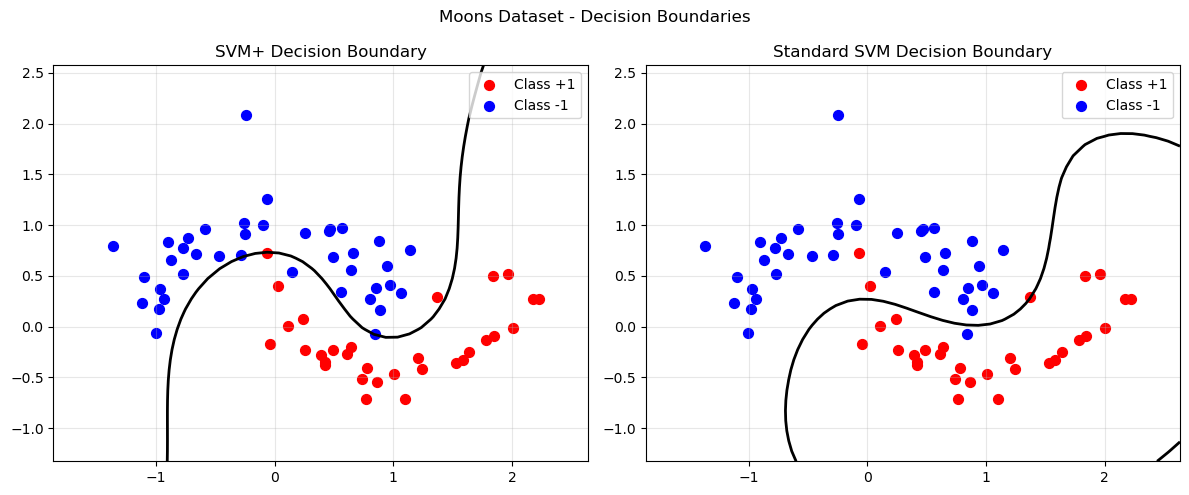

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_moons

# Import the SVMPlus class (assuming it's available)
# from svmplus import SVMPlus

def generate_noisy_data(n_samples=100):
    """Generate moons dataset with noise levels as privileged information"""
    np.random.seed(42)
    
    # Generate clean moons dataset
    X_clean, y = make_moons(n_samples=n_samples, noise=0.0, random_state=42)
    
    # Convert to {-1, 1}
    y = np.where(y == 0, -1, 1)
    
    # Generate varying noise levels
    noise_levels = np.random.uniform(0.05, 0.3, n_samples)
    
    # Add noise to data
    noise_x = np.random.randn(n_samples) * noise_levels
    noise_y = np.random.randn(n_samples) * noise_levels
    X_noisy = X_clean + np.column_stack([noise_x, noise_y])
    
    # Privileged information: noise characteristics
    X_star = np.column_stack([
        noise_levels,
        np.abs(noise_x),
        np.abs(noise_y),
        np.sqrt(noise_x**2 + noise_y**2)
    ])
    
    return X_noisy, X_star, y

def compare_models(n_samples=100):
    """Compare SVM+ vs Standard SVM performance"""
    
    # Generate data
    X, X_star, y = generate_noisy_data(n_samples)
    
    # Train/test split
    train_size = int(0.7 * n_samples)
    X_train, X_test = X[:train_size], X[train_size:]
    X_star_train = X_star[:train_size]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Train SVM+
    svm_plus = SVMPlus(C=1.0, gamma=1.0)
    svm_plus.fit(X_train, X_star_train, y_train)
    
    # Train Standard SVM
    svm_standard = SVC(kernel='rbf', C=1.0, gamma=1.0)
    svm_standard.fit(X_train, y_train)
    
    # Make predictions
    y_pred_plus = svm_plus.predict(X_test)
    y_pred_standard = svm_standard.predict(X_test)
    
    # Calculate accuracies
    acc_plus = np.mean(y_pred_plus == y_test)
    acc_standard = np.mean(y_pred_standard == y_test)
    
    return acc_plus, acc_standard

def simple_comparison():
    """Run simple comparison for moons dataset"""
    print("SVM+ vs Standard SVM Performance Comparison")
    print("=" * 50)
    print("Dataset: MOONS")
    
    # Run multiple trials for more reliable results
    svm_plus_scores = []
    svm_standard_scores = []
    
    for trial in range(5):  # 5 trials with different random seeds
        np.random.seed(42 + trial)
        acc_plus, acc_standard = compare_models(n_samples=100)
        svm_plus_scores.append(acc_plus)
        svm_standard_scores.append(acc_standard)
    
    # Calculate averages
    avg_plus = np.mean(svm_plus_scores)
    avg_standard = np.mean(svm_standard_scores)
    
    print(f"\nSVM+ Accuracy:      {avg_plus:.3f}")
    print(f"Standard SVM:       {avg_standard:.3f}")
    print(f"Improvement:        {avg_plus - avg_standard:+.3f}")
    
    return avg_plus, avg_standard

def plot_simple_boundaries(n_samples=100):
    """Very simple decision boundary visualization for moons"""
    np.random.seed(42)
    
    # Generate data
    X, X_star, y = generate_noisy_data(n_samples)
    
    # Train/test split
    train_size = int(0.7 * n_samples)
    X_train = X[:train_size]
    X_star_train = X_star[:train_size]
    y_train = y[:train_size]
    
    # Train both models
    svm_plus = SVMPlus(C=1.0, gamma=1.0)
    svm_plus.fit(X_train, X_star_train, y_train)
    
    svm_standard = SVC(kernel='rbf', C=1.0, gamma=1.0)
    svm_standard.fit(X_train, y_train)
    
    # Create simple mesh
    h = 0.1
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Simple side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # SVM+ plot
    Z1 = svm_plus.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z1 = Z1.reshape(xx.shape)
    ax1.contour(xx, yy, Z1, levels=[0], colors='black', linewidths=2)
    ax1.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
                c='red', s=50, label='Class +1')
    ax1.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], 
                c='blue', s=50, label='Class -1')
    ax1.set_title('SVM+ Decision Boundary')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Standard SVM plot
    Z2 = svm_standard.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z2 = Z2.reshape(xx.shape)
    ax2.contour(xx, yy, Z2, levels=[0], colors='black', linewidths=2)
    ax2.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
                c='red', s=50, label='Class +1')
    ax2.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], 
                c='blue', s=50, label='Class -1')
    ax2.set_title('Standard SVM Decision Boundary')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Moons Dataset - Decision Boundaries')
    plt.tight_layout()
    plt.show()
    
    return fig

# Simple execution
if __name__ == "__main__":
    # Performance comparison (just print results)
    simple_comparison()
    
    # Simple decision boundarie
    print("\nDecision Boundary Visualization:")
    print("=" * 40)
    plot_simple_boundaries(n_samples=100)

Multiclass SVM+ vs Standard SVM - 3-Class Dataset with Privileged Info
Training Multiclass SVM+...
Training Standard Multiclass SVM...

PERFORMANCE RESULTS
TRAINING ACCURACY:
  Multiclass SVM+:   1.000
  Standard SVM:      1.000
  Improvement:       +0.000

TEST ACCURACY:
  Multiclass SVM+:   0.967
  Standard SVM:      0.961
  Improvement:       +0.006

TRAINING MISCLASSIFIED POINTS:
  Multiclass SVM+:   0/120 points
  Standard SVM:      0/120 points
  Difference:        0 fewer errors with SVM+

TEST MISCLASSIFIED POINTS:
  Multiclass SVM+:   6/180 points
  Standard SVM:      7/180 points
  Difference:        1 fewer errors with SVM+
  Privileged features: 12


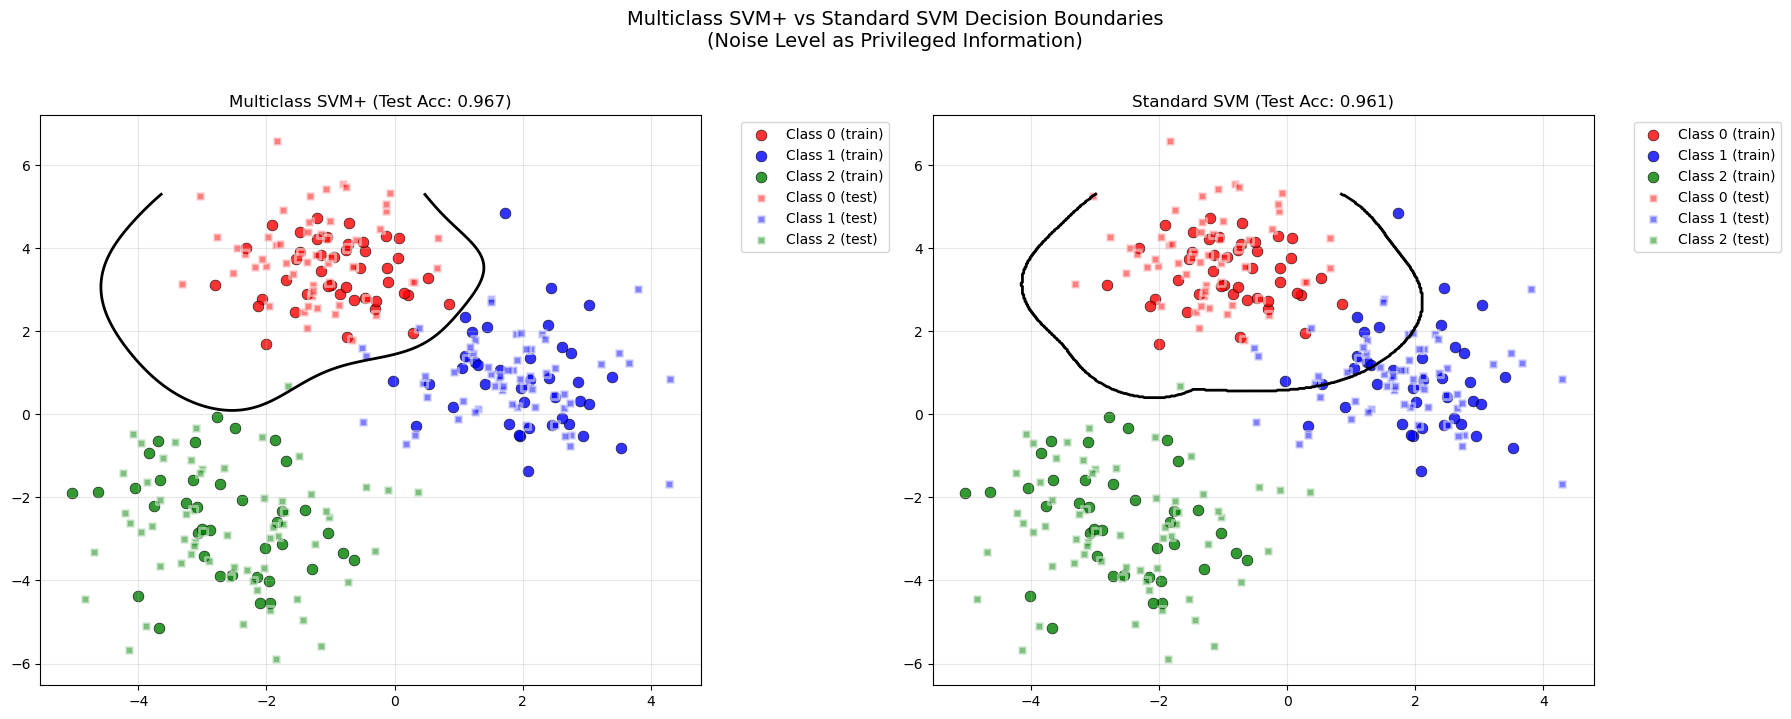

In [69]:
# Multiclass-only example with train/test accuracy
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    from sklearn.svm import SVC
    import matplotlib.pyplot as plt
    
    print("Multiclass SVM+ vs Standard SVM - 3-Class Dataset with Privileged Info")
    print("=" * 75)
    
    def plot_decision_boundary(X_train, y_train, X_test, y_test, clf, title, ax):
        """Plot decision boundary for a classifier with both train and test points"""
        h = 0.02
        # Use training data range for mesh
        x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
        y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        if hasattr(clf, 'classes_') and len(clf.classes_) > 2:
            # Multiclass - use first decision function
            if Z.ndim > 1:
                Z = Z[:, 0]
        Z = Z.reshape(xx.shape)
        
        ax.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
        colors = ['red', 'blue', 'green', 'orange']
        unique_y = np.unique(y_train)
        
        # Plot training points (solid colors, larger)
        for i, class_val in enumerate(unique_y):
            mask_train = y_train == class_val
            ax.scatter(X_train[mask_train, 0], X_train[mask_train, 1], 
                      c=colors[i % len(colors)], s=60, alpha=0.8,
                      label=f'Class {class_val} (train)', edgecolors='black', linewidth=0.5)
        
        # Plot test points (hollow/transparent, smaller)
        for i, class_val in enumerate(unique_y):
            mask_test = y_test == class_val
            ax.scatter(X_test[mask_test, 0], X_test[mask_test, 1], 
                      c=colors[i % len(colors)], s=40, alpha=0.5,
                      marker='s', edgecolors='white', linewidth=2,
                      label=f'Class {class_val} (test)')
        
        ax.set_title(title)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    # MULTICLASS CLASSIFICATION - 3-Class Blobs with Privileged Information
    np.random.seed(42)
    n_per_class = 100  # Increased sample size
    n_multi = 3 * n_per_class
    
    # Create 3 distinct blob clusters
    X_multi_clean, y_multi = make_blobs(
        n_samples=n_multi, 
        centers=3, 
        n_features=2,
        center_box=(-4, 4),  # Wider separation
        cluster_std=0.8,     # Controlled cluster spread
        random_state=42
    )
    
    # Add class-dependent noise with different characteristics
    noise_levels_multi = np.zeros(n_multi)
    noise_x_multi = np.zeros(n_multi)
    noise_y_multi = np.zeros(n_multi)
    data_quality = np.zeros(n_multi)  # Privileged feature
    
    for class_id in range(3):
        mask = y_multi == class_id
        n_class = np.sum(mask)
        
        if class_id == 0:
            # Class 0: Low noise, high quality
            noise_levels_multi[mask] = np.random.uniform(0.3, 0.7, n_class)
            data_quality[mask] = np.random.uniform(0.8, 1.0, n_class)
        elif class_id == 1:
            # Class 1: Low noise, high quality
            noise_levels_multi[mask] = np.random.uniform(0.3, 0.7, n_class)
            data_quality[mask] = np.random.uniform(0.8, 1.0, n_class)
        else:
            # Class 2: High noise, low quality
            noise_levels_multi[mask] = np.random.uniform(0.7, 1.3, n_class)
            data_quality[mask] = np.random.uniform(0.2, 0.4, n_class)
        
        # Generate correlated noise
        noise_x_multi[mask] = np.random.randn(n_class) * noise_levels_multi[mask]
        noise_y_multi[mask] = np.random.randn(n_class) * noise_levels_multi[mask]
    
    # Apply noise to create final dataset
    X_multi_noisy = X_multi_clean + np.column_stack([noise_x_multi, noise_y_multi])
    
    # EXTENSIVE privileged features for multiclass
    distance_to_center = np.sqrt(np.sum(X_multi_clean**2, axis=1))  # Distance from origin
    noise_magnitude = np.sqrt(noise_x_multi**2 + noise_y_multi**2)
    signal_to_noise = distance_to_center / (noise_magnitude + 1e-8)
    measurement_confidence = data_quality * (1 - noise_levels_multi)
    noise_asymmetry = np.abs(noise_x_multi) - np.abs(noise_y_multi)
    
    X_star_multi = np.column_stack([
        noise_levels_multi,      # Base noise level
        np.abs(noise_x_multi),   # X-direction noise
        np.abs(noise_y_multi),   # Y-direction noise  
        data_quality,            # Data collection quality
        distance_to_center,      # Distance from origin
        noise_magnitude,         # Total noise magnitude
        signal_to_noise,         # Signal-to-noise ratio
        measurement_confidence,  # Overall measurement confidence
        noise_asymmetry,         # Directional noise bias
        noise_x_multi * noise_y_multi,  # Noise interaction
        X_multi_clean[:, 0] * noise_levels_multi,  # Position-noise interaction X
        X_multi_clean[:, 1] * noise_levels_multi   # Position-noise interaction Y
    ])
    
    # Split multiclass data
    train_size_multi = int(0.4 * n_multi)
    indices = np.random.permutation(n_multi)
    train_idx, test_idx = indices[:train_size_multi], indices[train_size_multi:]
    
    X_train_multi = X_multi_noisy[train_idx]
    X_star_train_multi = X_star_multi[train_idx]
    y_train_multi, y_test_multi = y_multi[train_idx], y_multi[test_idx]
    X_test_multi = X_multi_noisy[test_idx]
    
    # Train multiclass classifiers
    print("Training Multiclass SVM+...")
    multiclass_svm_plus = MulticlassSVMPlus(C=1.0, gamma=1.0)
    multiclass_svm_plus.fit(X_train_multi, X_star_train_multi, y_train_multi)
    
    print("Training Standard Multiclass SVM...")
    svm_standard_multi = SVC(kernel='rbf', C=1.0, gamma=1.0)
    svm_standard_multi.fit(X_train_multi, y_train_multi)
    
    # Compute BOTH train and test accuracies
    print("\n" + "="*50)
    print("PERFORMANCE RESULTS")
    print("="*50)
    
    # Train accuracies
    train_pred_plus = multiclass_svm_plus.predict(X_train_multi)
    train_pred_standard = svm_standard_multi.predict(X_train_multi)
    train_acc_plus = np.mean(train_pred_plus == y_train_multi)
    train_acc_standard = np.mean(train_pred_standard == y_train_multi)
    
    # Test accuracies
    test_pred_plus = multiclass_svm_plus.predict(X_test_multi)
    test_pred_standard = svm_standard_multi.predict(X_test_multi)
    test_acc_plus = np.mean(test_pred_plus == y_test_multi)
    test_acc_standard = np.mean(test_pred_standard == y_test_multi)
    
    # Calculate misclassified points
    train_misclassified_plus = np.sum(train_pred_plus != y_train_multi)
    train_misclassified_standard = np.sum(train_pred_standard != y_train_multi)
    test_misclassified_plus = np.sum(test_pred_plus != y_test_multi)
    test_misclassified_standard = np.sum(test_pred_standard != y_test_multi)
    
    print(f"TRAINING ACCURACY:")
    print(f"  Multiclass SVM+:   {train_acc_plus:.3f}")
    print(f"  Standard SVM:      {train_acc_standard:.3f}")
    print(f"  Improvement:       {train_acc_plus - train_acc_standard:+.3f}")
    
    print(f"\nTEST ACCURACY:")
    print(f"  Multiclass SVM+:   {test_acc_plus:.3f}")
    print(f"  Standard SVM:      {test_acc_standard:.3f}")
    print(f"  Improvement:       {test_acc_plus - test_acc_standard:+.3f}")
    
    print(f"\nTRAINING MISCLASSIFIED POINTS:")
    print(f"  Multiclass SVM+:   {train_misclassified_plus}/{len(y_train_multi)} points")
    print(f"  Standard SVM:      {train_misclassified_standard}/{len(y_train_multi)} points")
    print(f"  Difference:        {train_misclassified_standard - train_misclassified_plus} fewer errors with SVM+")
    
    print(f"\nTEST MISCLASSIFIED POINTS:")
    print(f"  Multiclass SVM+:   {test_misclassified_plus}/{len(y_test_multi)} points")
    print(f"  Standard SVM:      {test_misclassified_standard}/{len(y_test_multi)} points")
    print(f"  Difference:        {test_misclassified_standard - test_misclassified_plus} fewer errors with SVM+")
    
    print(f"  Privileged features: {X_star_multi.shape[1]}")
    
    # PLOT DECISION BOUNDARIES
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Plot decision boundaries with both train and test points
    plot_decision_boundary(X_train_multi, y_train_multi, X_test_multi, y_test_multi, 
                          multiclass_svm_plus, 
                          f'Multiclass SVM+ (Test Acc: {test_acc_plus:.3f})', ax1)
    plot_decision_boundary(X_train_multi, y_train_multi, X_test_multi, y_test_multi,
                          svm_standard_multi, 
                          f'Standard SVM (Test Acc: {test_acc_standard:.3f})', ax2)
    
    plt.suptitle('Multiclass SVM+ vs Standard SVM Decision Boundaries\n(Noise Level as Privileged Information)', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()